In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image  
import time

import torchvision
import torchvision.transforms as transforms
import torchvision.utils
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from utils import toumap, totsne, plotsmart
from utils import getallranks, calcmap
from utils import bestk_silhouette_score, getclusters_ws

from dataset import CustomDataset, DatasetFeatsTrain, dsbuild
from model import netmodel
from loss import HybridLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

print('Using device:', torch.cuda.is_available(), torch.cuda.get_device_name(0))

Using device: True NVIDIA GeForce RTX 4090


# Feature Extraction

**Pre-traineded models**

In [3]:
from timm import create_model
import timm

# timm.list_models("*convnex*", pretrained=True)
netfeat = create_model("convnext_xxlarge.clip_laion2b_soup_ft_in12k", pretrained=True).to(device)
netfeat.head.fc = torch.nn.Identity()
netfeat.to(device)
netfeat.eval()

def getfeat(x):
    with torch.no_grad():
        X = netfeat(x)
    return X   

In [5]:
class ConvertTo3Channels:
    def __call__(self, img):
        # Se a imagem já tiver 3 canais, retorne-a como está
        if img.mode == "RGB":
            return img
        # Caso contrário, converta-a para RGB
        return img.convert("RGB")
    
transform = transforms.Compose(
    [
        ConvertTo3Channels(),
        transforms.Resize((224, 224), transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor()
    ]
)

def configfeats(ds):
    with torch.no_grad():
        ds.feats = [[getfeat(d.unsqueeze(0).to(device))[0].cpu(), l] for d, l in ds]

ds = torchvision.datasets.FashionMNIST('~/lab/ds',train = True, transform=transform, download=True)
dstest = torchvision.datasets.FashionMNIST('~/lab/ds',train = False, transform=transform, download=True)

configfeats(ds)
configfeats(dstest)
len(ds.data)


60000

# Clustering and centroid computation

In [ ]:
#xtsne = totsne([f for f, l in ds.feats])
# plotsmart(xtsne, [l for _, l in ds.feats])

**Clustering step**

K score 3 : 0.37517965
K score 4 : 0.38979536
K score 5 : 0.38615033
K score 6 : 0.39675707
K score 7 : 0.40619546
K score 8 : 0.41307986
K score 9 : 0.41382292
K score 10 : 0.4133578
K score 11 : 0.41804236
K score 12 : 0.41789454
K score 13 : 0.40804836
K score 14 : 0.41077238
K score 15 : 0.39564162
K score 16 : 0.38713938
K score 17 : 0.39622462
K score 18 : 0.38911805
K score 19 : 0.39212838
K score 20 : 0.3899398
K score 21 : 0.39594048
K score 22 : 0.3972456
K score 23 : 0.40219232
K score 24 : 0.40366757
K score 25 : 0.4073942
K score 26 : 0.4010504
K score 27 : 0.39884707
K score 28 : 0.39812306
K score 29 : 0.39418393


/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


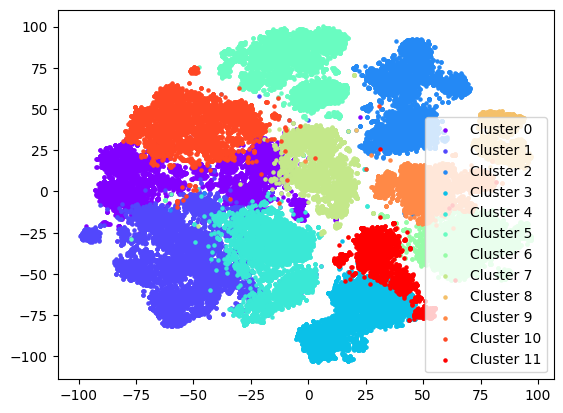

In [28]:
from sklearn.cluster import  AgglomerativeClustering

feats = [f for f,_ in ds.feats]
X = totsne(feats)

sampling_factor = 0.5 # for fast silhouette_score
idxs_sampling = random.sample(range(len(ds.feats)), round(len(ds.feats) * sampling_factor))
xsampling = totsne([feats[i] for i in idxs_sampling])
nclusters = bestk_silhouette_score(xsampling, rangeend=30) #get_nclusters(feats)

agg = AgglomerativeClustering(n_clusters=nclusters)
clusterlbs = agg.fit_predict(toumap(feats))
plotsmart(X, clusterlbs)

# Teacher neural network model

In [29]:
def getpar(ds):
    idxa = random.randint(0, len(ds.feats)-1)
    anchor, cl = ds.feats[idxa]

    is_same_class = random.choice([True, False])
    if is_same_class:
        pairidx = random.choice(ds.lbclassrel[cl.item()])
    else:
        cls = ds.idclasses.copy()
        cls.remove(cl.item())
        pairidx = random.choice(ds.lbclassrel[random.choice(cls)])
        
    pair_img, clp = ds.feats[pairidx]
    #print(cl, clp)
    mgadd = torch.tensor(ds.clusters_ws[cl.item()][clp.item()])
    return anchor, pair_img, torch.tensor(int(not is_same_class)), cl, clp, mgadd

def getbatch(ds, nbatch=32):
    ret = [getpar(ds) for n in range(nbatch)]
    anchors, pars, lbs, albs, plbs, mgs = [], [], [], [], [], []
    for r in ret:
        anchors.append(r[0])
        pars.append(r[1])
        lbs.append(r[2])
        albs.append(r[3])
        plbs.append(r[4])
        mgs.append(r[5])
    # [r[0] for r in ret], [r[1] for r in ret],[r[2] for r in ret]
    return torch.stack(anchors, dim=0), torch.stack(pars, dim=0), torch.stack(lbs, dim=0), torch.stack(albs, dim=0), torch.stack(plbs, dim=0), torch.stack(mgs, dim=0)

In [8]:

class histloss():
    def __init__(self) -> None:
        self.histloss =[]

hloss = histloss()

def treino(model, ds, n_epochs=1000, _margin = 2.0, _batchsize = 128):

    optimizer = optim.AdamW(model.parameters(), lr=0.0014)
    criterion = HybridLoss(margin=_margin)  # ContrastiveLoss(margin=_margin) 

    model.train()
    lossacum = 0

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        ctd = 0
        start = time.time()

        img1, img2, label, lbs1, lbs2, mgadd = getbatch(ds, _batchsize)
        img1, img2, label, lbs1, lbs2, mgadd = img1.to(device), img2.to(device), label.to(device), lbs1.to(device), lbs2.to(device), mgadd.to(device) 
        optimizer.zero_grad()
        
        #img1, img2 = F.normalize(img1, dim=1), F.normalize(img2, dim=1)
        #print(img1.shape)
        _, outlbs1, ored1 = model(img1)     
        _, outlbs2, ored2 = model(img2)

        outlbs = F.log_softmax(torch.cat([outlbs1, outlbs2]), dim=0)
        rotulos = torch.cat([lbs1, lbs2])

        perda_instantanea = criterion(label, outlbs, rotulos, ored1, ored2, mgadd)  
        #perda_instantanea = criteriosmax(outlbs, rotulos) 
        perda_instantanea.backward()
        optimizer.step()

        running_loss += perda_instantanea.item() # loss_contrastive.item()
        lossacum += running_loss                 
        ctd+=1

        if epoch> 0 :  # print every 10 mini-batches
            print('[%d] loss: %.5f' %
                    (epoch + 1, running_loss / ctd), 'time: ' + str(time.time() - start))
            hloss.histloss.append(running_loss / ctd)
            running_loss = 0.0
            ctd = 0

    print('Finished Training')
    ds.training = False
    return n_epochs, lossacum

In [30]:
import time

dstrain = DatasetFeatsTrain([ [f, torch.tensor(l)] for f,l in zip([f for f,_ in ds.feats], clusterlbs)], list(set([l.item() for l in clusterlbs])))
dstrain.clusters_ws = getclusters_ws(feats, clusterlbs)

for idc in dstrain.clusters_ws:
    for idr in dstrain.clusters_ws[idc]:
        dstrain.clusters_ws[idc][idr] = 0

net = netmodel(out_dim=len(dstrain.idclasses), in_dim=3072).to(device)

treino(net, dstrain, 1000, _margin=0.5, _batchsize = 2048)

[2] loss: 0.91823 time: 0.32103800773620605
[3] loss: 0.53752 time: 0.3250553607940674
[4] loss: 0.41769 time: 0.3271477222442627
[5] loss: 0.36574 time: 0.32404136657714844
[6] loss: 0.31750 time: 0.3237156867980957
[7] loss: 0.29115 time: 0.32146692276000977
[8] loss: 0.27937 time: 0.3294823169708252
[9] loss: 0.27546 time: 0.3358640670776367
[10] loss: 0.26792 time: 0.3255743980407715
[11] loss: 0.26128 time: 0.32201337814331055
[12] loss: 0.24798 time: 0.3332662582397461
[13] loss: 0.24408 time: 0.32483339309692383
[14] loss: 0.23889 time: 0.32297563552856445
[15] loss: 0.23863 time: 0.3288118839263916
[16] loss: 0.23018 time: 0.32578539848327637
[17] loss: 0.22686 time: 0.3274726867675781
[18] loss: 0.21884 time: 0.33162617683410645
[19] loss: 0.21634 time: 0.3217039108276367
[20] loss: 0.22785 time: 0.3272438049316406
[21] loss: 0.22521 time: 0.32683324813842773
[22] loss: 0.21197 time: 0.32424211502075195
[23] loss: 0.20988 time: 0.32896924018859863
[24] loss: 0.20966 time: 0.33

(1000, 55.345627943985164)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


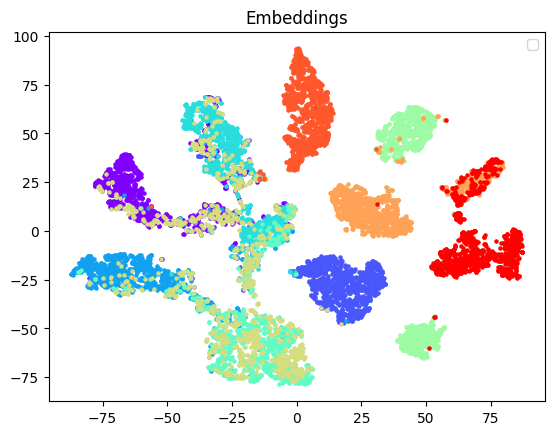

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


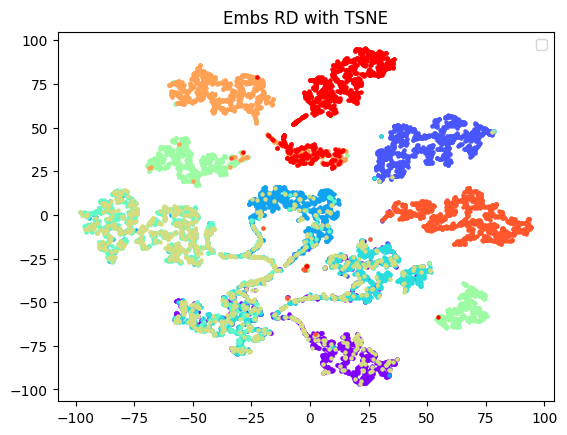

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


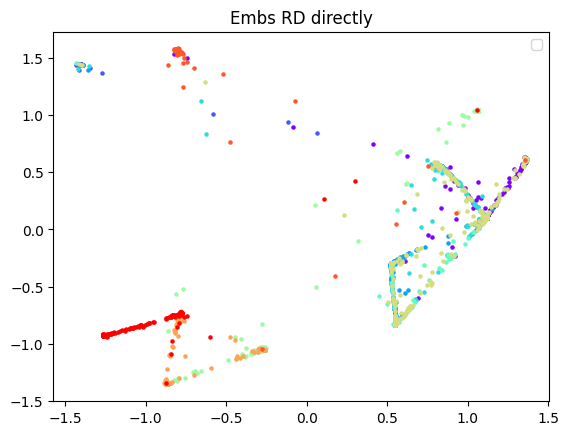

In [31]:
net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to(device).unsqueeze(0)) for f,l in dstest.feats], [l for f,l in dstest.feats]
#.cpu().squeeze()
#plotsmart(totsne( fs), lbs, "", True)
fsembs, fsreduc = [f[0].cpu().squeeze() for f in fs], [f[2].cpu().squeeze() for f in fs]

plotsmart(totsne(fsembs), lbs, "Embeddings", True)
plotsmart(totsne(fsreduc), lbs, "Embs RD with TSNE", True)
plotsmart(np.array(fsreduc), lbs, "Embs RD directly", True)

In [32]:
res = {}

In [33]:
# print()
print("Método proposto sem margem moderada")
ranks = getallranks(fsreduc)
resmap = calcmap(ranks, lbs)
res['ours_not_mg'] = resmap
resmap

Método proposto sem margem moderada


0.6618832912294285

In [35]:
dstrain = DatasetFeatsTrain([ [f, torch.tensor(l)] for f,l in zip([f for f,_ in ds.feats], clusterlbs)], list(set([l.item() for l in clusterlbs])))
dstrain.clusters_ws = getclusters_ws(feats, clusterlbs)

hloss = histloss()
net = netmodel(out_dim=len(dstrain.idclasses), in_dim=3072).to(device)

treino(net, dstrain, 1000, _margin=0.5, _batchsize = 2048)

[2] loss: 1.16977 time: 0.16332316398620605
[3] loss: 0.75010 time: 0.17051005363464355
[4] loss: 0.52872 time: 0.17074131965637207
[5] loss: 0.46014 time: 0.1714932918548584
[6] loss: 0.42282 time: 0.16281723976135254
[7] loss: 0.41337 time: 0.17310166358947754
[8] loss: 0.38778 time: 0.17649483680725098
[9] loss: 0.38134 time: 0.17499732971191406
[10] loss: 0.37970 time: 0.17725801467895508
[11] loss: 0.35732 time: 0.16767001152038574
[12] loss: 0.35213 time: 0.17475056648254395
[13] loss: 0.32773 time: 0.1662459373474121
[14] loss: 0.33544 time: 0.17537736892700195
[15] loss: 0.32359 time: 0.17500591278076172
[16] loss: 0.31451 time: 0.17254924774169922
[17] loss: 0.31413 time: 0.16995739936828613
[18] loss: 0.31877 time: 0.17128753662109375
[19] loss: 0.31460 time: 0.1757969856262207
[20] loss: 0.30601 time: 0.16316723823547363
[21] loss: 0.29559 time: 0.17818927764892578
[22] loss: 0.28668 time: 0.17813944816589355
[23] loss: 0.29785 time: 0.1740264892578125
[24] loss: 0.28426 tim

(1000, 77.86843678626006)

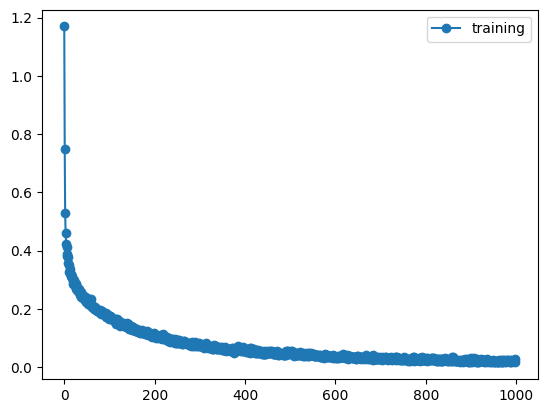

In [37]:
plt.plot(hloss.histloss, 'o-', label='training')
plt.legend()
plt.show()

#validafeats(net, device, [ f for f, _ in ds.feats], [ l for _, l in ds.feats])
#validafeats(net, device, [f for f, _ in dstest.feats], [ l for _, l in dstest.feats])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


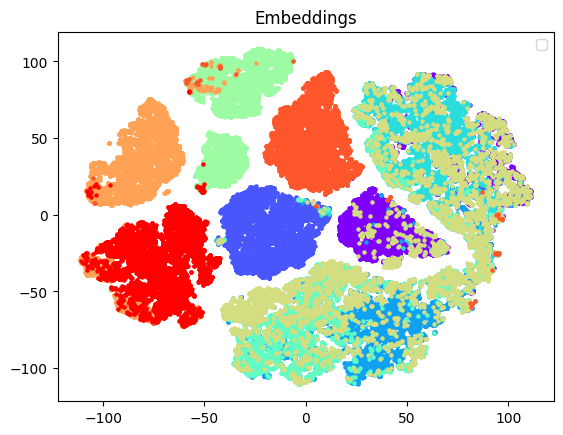

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


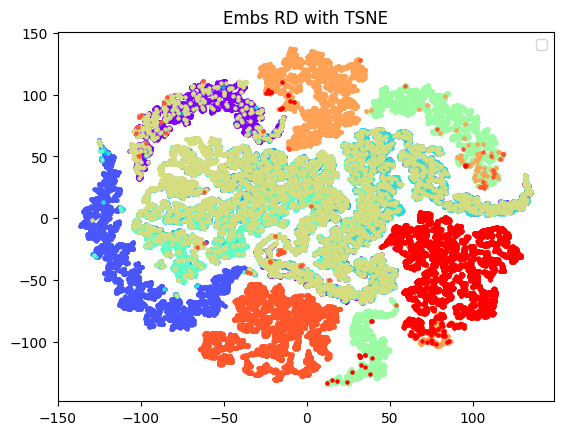

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


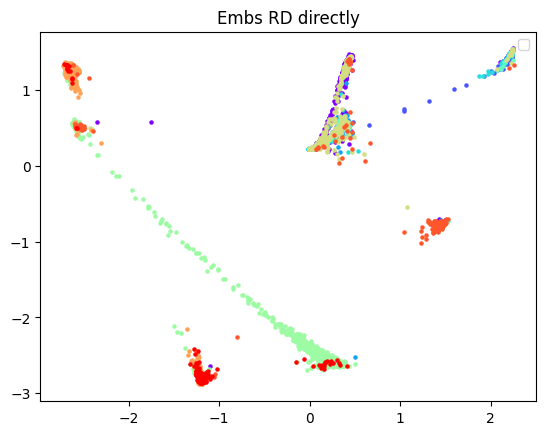

In [15]:
net.eval()
with torch.no_grad():
    trainfs, lbs = [net(f.to("cuda").unsqueeze(0)) for f,l in ds.feats], [l for f,l in ds.feats]
#.cpu().squeeze()
#plotsmart(totsne( fs), lbs, "", True)
trainfsembs, trainfsreduc = [f[0].cpu().squeeze() for f in trainfs], [f[2].cpu().squeeze() for f in trainfs]

plotsmart(totsne(trainfsembs), lbs, "Embeddings", True)
plotsmart(totsne(trainfsreduc), lbs, "Embs RD with TSNE", True)
plotsmart(np.array(trainfsreduc), lbs, "Embs RD directly", True)

**TEST Set**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


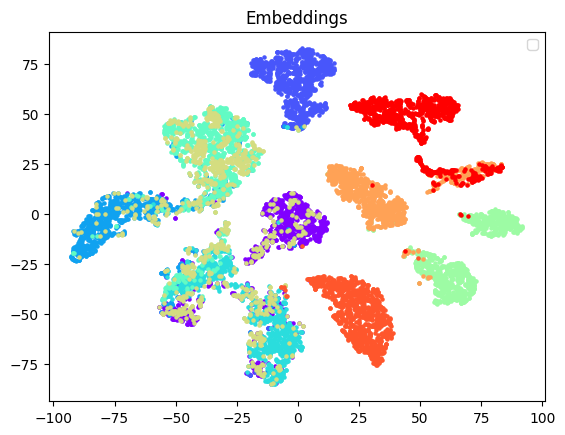

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


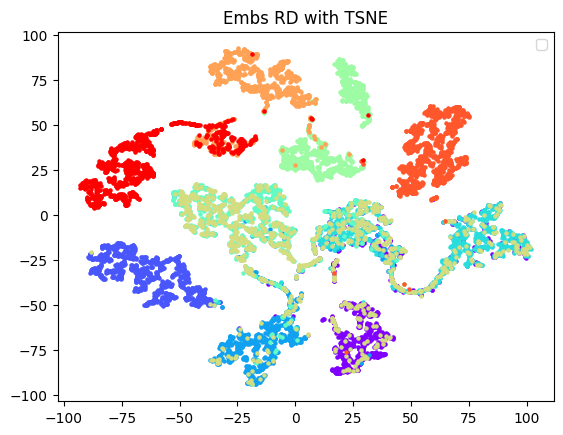

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


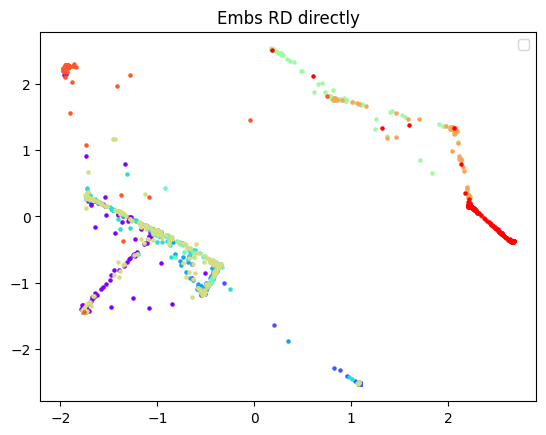

In [39]:
net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to(device).unsqueeze(0)) for f,l in dstest.feats], [l for f,l in dstest.feats]
#.cpu().squeeze()
#plotsmart(totsne( fs), lbs, "", True)
fsembs, fsreduc = [f[0].cpu().squeeze() for f in fs], [f[2].cpu().squeeze() for f in fs]

plotsmart(totsne(fsembs), lbs, "Embeddings", True)
plotsmart(totsne(fsreduc), lbs, "Embs RD with TSNE", True)
plotsmart(np.array(fsreduc), lbs, "Embs RD directly", True)

In [40]:
# print()
print("Método proposto")
ranks = getallranks(fsreduc)
resmap = calcmap(ranks, lbs)
res['ours_with_mg'] = resmap
resmap

Método proposto


0.7111127178266491

In [42]:
print("Método proposto High Dim")
ranks = getallranks(fsembs)
resmap = calcmap(ranks, lbs)
res['ours_with_mg_highdim'] = resmap
resmap

Método proposto High Dim


0.7141734397992803

In [43]:
print("Sem projeção")
X = [f for f,l in dstest.feats]
ranks = getallranks(X)
resmap = calcmap(ranks, lbs)
res['no_projection'] = resmap
resmap

Sem projeção


0.6336239100469502

In [45]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

print("PCA")
X = [f for f,l in dstest.feats]
X_pca = pca.fit_transform(X)
ranks = getallranks(torch.tensor(X_pca))
resmap = calcmap(ranks, lbs)
res['pca'] = resmap
resmap

PCA


0.5403431915551634

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


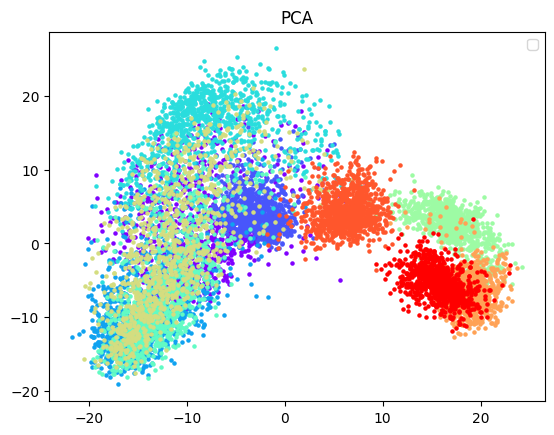

In [46]:
plotsmart(X_pca, lbs, "PCA", True)

In [47]:
print("T-SNE")
X = [f for f,l in dstest.feats]
ranks = getallranks(torch.tensor(totsne(X)))
resmap = calcmap(ranks, lbs)
res['tsne'] = resmap
resmap

T-SNE


0.7424349178105458

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


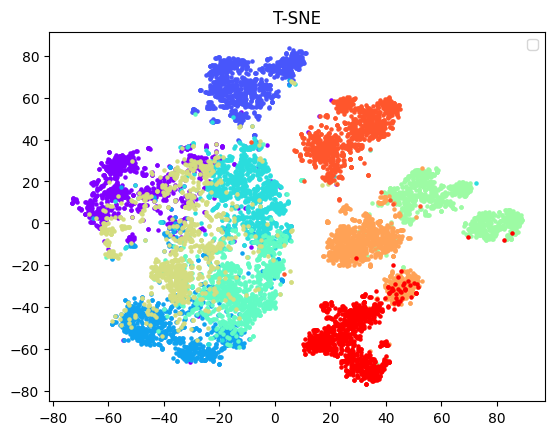

In [48]:
plotsmart(totsne(X), lbs, "T-SNE", True)

In [49]:
print("UMAP")
X = [f for f,l in dstest.feats]
ranks = getallranks(torch.tensor(toumap(X)))
resmap = calcmap(ranks, lbs)
res['umap'] = resmap
resmap

/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP


0.7553253660992699

/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


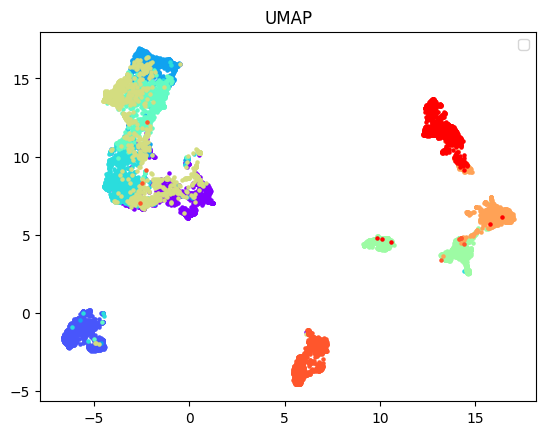

In [50]:
plotsmart(toumap(X), lbs, "UMAP", True)

In [51]:
res

{'ours_not_mg': 0.6618832912294285,
 'ours_with_mg': 0.7111127178266491,
 'ours_with_mg_highdim': 0.7141734397992803,
 'no_projection': 0.6336239100469502,
 'pca': 0.5403431915551634,
 'tsne': 0.7424349178105458,
 'umap': 0.7553253660992699}